In [21]:
# !pip install matplotlib
#!pip install scikit-learn
#!pip install kaggle

In [1]:
import os
import shutil

In [25]:
# CONFIGURA TU RUTA AQUÍ
KAGGLE_JSON_PATH = os.path.expanduser("/home/deynar/Descargas/kaggle.json")  # O la ruta donde está tu kaggle.json
KAGGLE_CONFIG_DIR = os.path.expanduser("kaggle")
os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)

In [26]:
if os.path.exists(KAGGLE_JSON_PATH):
    shutil.copy(KAGGLE_JSON_PATH, os.path.join(KAGGLE_CONFIG_DIR, "kaggle.json"))
    os.chmod(os.path.join(KAGGLE_CONFIG_DIR, "kaggle.json"), 0o600)
    print("✓ Credenciales de Kaggle configuradas correctamente")
else:
    print("✗ Error: No se encontró kaggle.json en la ruta especificada")
    print(f"Ruta buscada: {KAGGLE_JSON_PATH}")

✓ Credenciales de Kaggle configuradas correctamente


In [27]:
!kaggle datasets download -d sergeynesteruk/minerals --unzip -p minerals

Dataset URL: https://www.kaggle.com/datasets/sergeynesteruk/minerals
License(s): CC-BY-NC-SA-4.0
100%|█████████████████████████████████████▉| 5.93G/5.93G [04:21<00:00, 25.0MB/s]
100%|██████████████████████████████████████| 5.93G/5.93G [04:21<00:00, 24.3MB/s]


In [1]:
import os

print("Estructura del dataset:")
for root, dirs, files in os.walk(DATASET_PATH, topdown=True):
    level = root.replace(DATASET_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    # Mostrar solo los primeros 5 archivos de cada carpeta
    for i, file in enumerate(files[:5]):
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... ({len(files)-5} archivos más)")


Estructura del dataset:
/
  minerals_full.csv
mineral_images/
  data/
    10_meteor/
      10_1/
        FMM_10_1.jpg
      10_10/
        10_10.jpg
      10_100/
        10_100.jpg
      10_101/
        10_101.jpg
      10_103/
        10_103.jpg
      10_104/
        10_104.jpg
      10_105/
        10_105.jpg
      10_107/
        10_107.jpg
      10_108/
        10_108.jpg
      10_109/
        10_109.jpg
      10_11/
        FMM_10_11.JPG
      10_111/
        10_111.jpg
      10_112/
        10_112.jpg
      10_113/
        10_113.jpg
      10_114/
        10_114.jpg
      10_115/
        10_115.jpg
      10_116/
        10_116.jpg
      10_117/
        10_117.jpg
      10_119/
        10_119.jpg
      10_12/
        IMG_6405.JPG
      10_121/
        10_121.jpg
      10_122/
        10_122.jpg
      10_123/
        10_123.jpg
      10_124/
        10_124.jpg
      10_125/
        10_125.jpg
      10_126/
        10_126.jpg
      10_127/
        10_127.jpg
      10_128/
        1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

2025-11-27 17:02:01.596604: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 17:02:01.660998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 17:02:05.490762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# ============================================
# CONFIGURACIÓN DEL ENTRENAMIENTO
# ============================================

DATASET_PATH = "minerals/"
# Parámetros de imagen
IMG_SIZE = (224, 224)  # EfficientNetB3 recomienda 224x224 o 300x300
BATCH_SIZE = 16  # Reducir si tienes poca VRAM (8, 4)
EPOCHS = 50  # EarlyStopping detendrá automáticamente si es necesario

# Rutas
MODEL_SAVE_PATH = "mineral_recognition_model.h5"
CLASSES_JSON_PATH = "mineral_classes.json"

# Parámetros del modelo
FINE_TUNE_AT = 150  # Capa desde donde descongelar EfficientNet
DROPOUT_RATE = 0.5

print("Configuración establecida:")
print(f"- Tamaño de imagen: {IMG_SIZE}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Epochs máximos: {EPOCHS}")
print(f"- Modelo se guardará en: {MODEL_SAVE_PATH}")

Configuración establecida:
- Tamaño de imagen: (224, 224)
- Batch size: 16
- Epochs máximos: 50
- Modelo se guardará en: mineral_recognition_model.h5


Total de imágenes: 31035
Número de clases: 1

Top 10 clases con más imágenes:
         Clase  Imágenes
mineral_images     31035


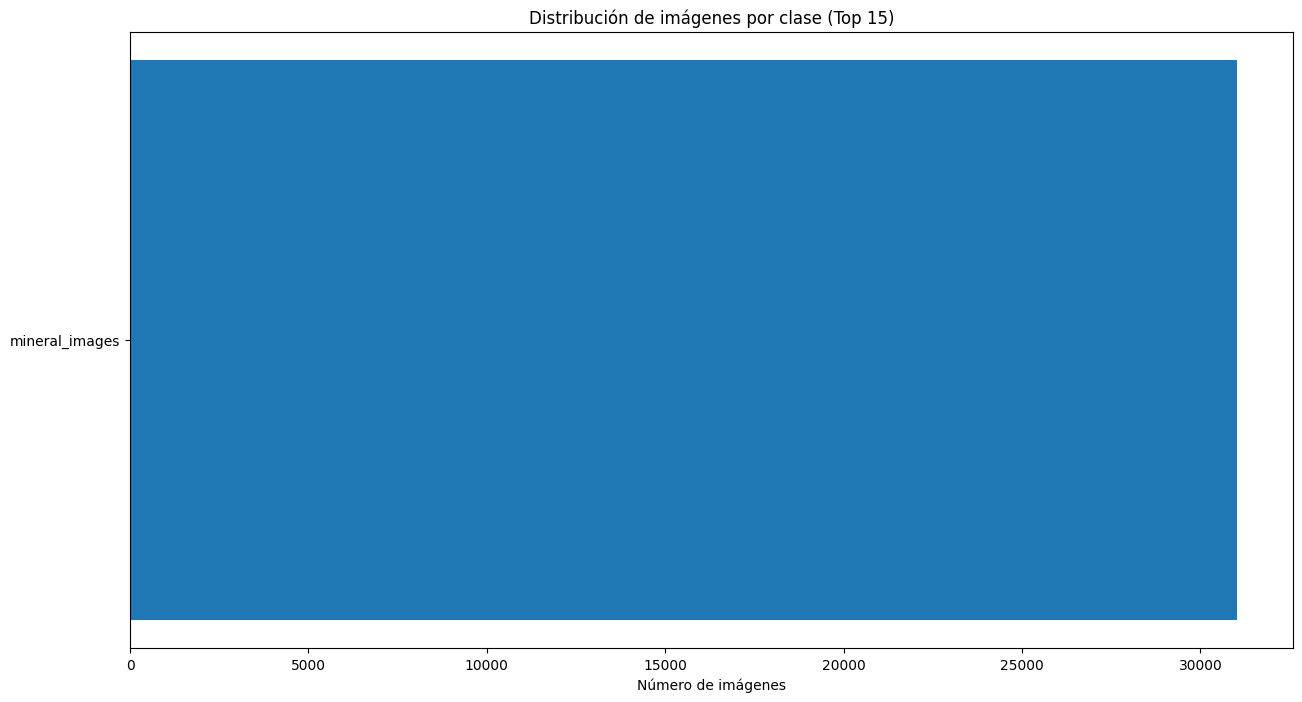


✓ Clases guardadas en mineral_classes.json


In [4]:
# ============================================
# ANÁLISIS DE CLASES Y DISTRIBUCIÓN
# ============================================
def explore_dataset(dataset_path):
    """Analiza el dataset incluyendo subcarpetas infinitas"""
    classes = {}
    total_images = 0
    
    for class_name in sorted(os.listdir(dataset_path)):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            
            # Recorrer TODAS las subcarpetas
            n_images = 0
            for root, _, files in os.walk(class_path):
                n_images += len([f for f in files if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
            
            classes[class_name] = n_images
            total_images += n_images
    
    # Crear DataFrame
    df = pd.DataFrame(list(classes.items()), columns=['Clase', 'Imágenes'])
    df = df.sort_values('Imágenes', ascending=False)
    
    print(f"Total de imágenes: {total_images}")
    print(f"Número de clases: {len(classes)}")
    print("\nTop 10 clases con más imágenes:")
    print(df.head(10).to_string(index=False))

    # Distribución
    plt.figure(figsize=(15, 8))
    plt.barh(df['Clase'][:15], df['Imágenes'][:15])
    plt.xlabel('Número de imágenes')
    plt.title('Distribución de imágenes por clase (Top 15)')
    plt.gca().invert_yaxis()
    plt.show()
    
    return list(classes.keys())



CLASSES = explore_dataset(DATASET_PATH)
NUM_CLASSES = len(CLASSES)

# Guardar clases
with open(CLASSES_JSON_PATH, "w") as f:
    json.dump(CLASSES, f)
print(f"\n✓ Clases guardadas en {CLASSES_JSON_PATH}")

In [5]:
# ============================================
# GENERADORES DE DATOS (AUMENTO DE DATOS)
# ============================================

def create_data_generators():
    """Crea generadores de entrenamiento y validación"""
    
    # Aumento de datos para entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        shear_range=0.1,
        fill_mode='nearest',
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
        validation_split=0.2  # 20% para validación
    )
    
    # Solo rescale para validación
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
        validation_split=0.2
    )
    
    # Generador de entrenamiento
    train_generator = train_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    # Generador de validación
    validation_generator = valid_datagen.flow_from_directory(
        DATASET_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
        seed=42
    )
    
    print(f"✓ Generadores creados:")
    print(f"  - Training batches: {len(train_generator)}")
    print(f"  - Validation batches: {len(validation_generator)}")
    print(f"  - Clases: {train_generator.num_classes}")
    
    return train_generator, validation_generator

train_gen, val_gen = create_data_generators()

Found 24828 images belonging to 1 classes.
Found 6207 images belonging to 1 classes.
✓ Generadores creados:
  - Training batches: 1552
  - Validation batches: 388
  - Clases: 1


In [6]:
# ============================================
# CONSTRUCCIÓN DEL MODELO EFFICIENTNETB3
# ============================================

def build_efficientnet_model(num_classes):
    """Construye modelo con EfficientNetB3"""
    
    # Cargar EfficientNetB3 pre-entrenado en ImageNet
    base_model = tf.keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3),
        pooling=None
    )
    
    # Congelar el modelo base inicialmente
    base_model.trainable = False
    
    # Construir modelo completo
    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    
    # Capas de cabeza (head)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(DROPOUT_RATE * 0.6)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(DROPOUT_RATE * 0.3)(x)
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    print("✓ Modelo construido")
    print(f"  - Capas base (congeladas): {len(base_model.layers)}")
    print(f"  - Parámetros totales: {model.count_params():,}")
    
    return model, base_model

model, base_model = build_efficientnet_model(NUM_CLASSES)

# Mostrar resumen
model.summary()

2025-11-27 17:02:18.816638: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-11-27 17:02:18.817026: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:160] env: CUDA_VISIBLE_DEVICES="-1"
2025-11-27 17:02:18.817035: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] CUDA_VISIBLE_DEVICES is set to -1 - this hides all GPUs from CUDA
2025-11-27 17:02:18.817042: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:171] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-11-27 17:02:18.817048: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:176] retrieving CUDA diagnostic information for host: borderlands-dev
2025-11-27 17:02:18.817052: I external/local_xla/xla/stream_executor/cu

✓ Modelo construido
  - Capas base (congeladas): 385
  - Parámetros totales: 11,702,064


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,702,064 (44.64 MB)

 Trainable params: 918,529 (3.50 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [7]:
# ============================================
# FASE 1: ENTRENAMIENTO SOLO DE LA CABEZA
# ============================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

print("✓ Modelo compilado para entrenamiento de cabeza")
print("  - Learning rate: 0.001")
print("  - Capas base: CONGELADAS")

✓ Modelo compilado para entrenamiento de cabeza
  - Learning rate: 0.001
  - Capas base: CONGELADAS


In [8]:
# ============================================
# CALLBACKS: EARLY STOPPING, CHECKPOINT, LR SCHEDULER
# ============================================

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,  # Parar si no mejora en 10 épocas
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    ),
    callbacks.CSVLogger(
        "training_log.csv",
        append=True
    )
]

print("Callbacks configurados:")
for cb in callbacks_list:
    print(f"  - {cb.__class__.__name__}")

Callbacks configurados:
  - EarlyStopping
  - ReduceLROnPlateau
  - ModelCheckpoint
  - CSVLogger


In [9]:
# ============================================
# ENTRENAMIENTO FASE 1: CABEZA DEL MODELO
# ============================================

print("="*60)
print("INICIANDO FASE 1: ENTRENAMIENTO DE CABEZA")
print("="*60)

history_phase1 = model.fit(
    train_gen,
    epochs=min(10, EPOCHS),  # Máximo 10 épocas para fase 1
    validation_data=val_gen,
    callbacks=callbacks_list,
    verbose=1
)


INICIANDO FASE 1: ENTRENAMIENTO DE CABEZA
Epoch 1/10
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000
Epoch 1: val_accuracy improved from None to 1.00000, saving model to mineral_recognition_model.h5


1552/1552 ━━━━━━━━━━━━━━━━━━━━ 1088s 693ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 2/10
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000
Epoch 2: val_accuracy did not improve from 1.00000
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 548s 353ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 3/10
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 1.00000
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 621s 400ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - top3_accuracy: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - val_top3_accuracy: 1.0000 - learning_rate: 0.0010
Epoch 4/10
1552/1552 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# ============================================
# FASE 2: FINE-TUNING (DESCONGELAR CAPAS)
# ============================================

# Descongelar capas del modelo base
base_model.trainable = True

# Configurar qué capas descongelar
print(f"Descongelando capas a partir de la capa {FINE_TUNE_AT}...")
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= FINE_TUNE_AT

# Contar parámetros entrenables
trainable_params = np.sum([keras.backend.count_params(w) for w in model.trainable_weights])
total_params = model.count_params()

print(f"Parámetros entrenables: {trainable_params:,} ({trainable_params/total_params*100:.1f}%)")

In [ ]:
# ============================================
# RECOMPILAR CON LR MÁS BAJO PARA FINE-TUNING
# ============================================

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # LR 10x menor
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')
    ]
)

print("✓ Modelo recompilado para fine-tuning")
print("  - Learning rate: 0.0001")
print("  - Capas descongeladas: Desde capa", FINE_TUNE_AT)

In [ ]:
# ============================================
# ENTRENAMIENTO FASE 2: FINE-TUNING COMPLETO
# ============================================

print("="*60)
print("INICIANDO FASE 2: FINE-TUNING")
print("="*60)

history_phase2 = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks_list,
    verbose=1,
    initial_epoch=history_phase1.epoch[-1]  # Continuar desde última época
)

In [ ]:
# ============================================
# EVALUACIÓN Y REPORTE DE RESULTADOS
# ============================================

def evaluate_model(model, val_generator, classes):
    """Evaluación detallada del modelo"""
    
    print("="*60)
    print("EVALUACIÓN FINAL DEL MODELO")
    print("="*60)
    
    # Métricas generales
    loss, accuracy, top3_accuracy = model.evaluate(val_generator, verbose=1)
    print(f"\nResultados en validación:")
    print(f"  - Loss: {loss:.4f}")
    print(f"  - Accuracy: {accuracy:.4f}")
    print(f"  - Top-3 Accuracy: {top3_accuracy:.4f}")
    
    # Predicciones para reporte de clasificación
    print("\nGenerando reporte de clasificación...")
    val_generator.reset()
    predictions = model.predict(val_generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_generator.classes
    
    # Reporte
    print("\nReporte de clasificación (Top 10 clases):")
    report = classification_report(
        y_true, y_pred,
        target_names=classes,
        output_dict=True,
        zero_division=0
    )
    
    report_df = pd.DataFrame(report).transpose()
    print(report_df.sort_values('support', ascending=False).head(10).to_string())
    
    return report_df

# Cargar el mejor modelo
best_model = models.load_model(MODEL_SAVE_PATH)

# Evaluar
report = evaluate_model(best_model, val_gen, CLASSES)

In [ ]:
# ============================================
# EXPORTAR MODELO EN FORMATO .h5
# ============================================

# Guardar modelo completo
best_model.save(MODEL_SAVE_PATH, save_format='h5')
print(f"\n✓ MODELO GUARDADO: {MODEL_SAVE_PATH}")

# Verificar tamaño del archivo
import os
size_mb = os.path.getsize(MODEL_SAVE_PATH) / (1024 * 1024)
print(f"  - Tamaño del modelo: {size_mb:.2f} MB")

In [ ]:
# ============================================
# SISTEMA DE LOCALIZACIÓN (GRAD-CAM + BOUNDING BOX)
# ============================================

class MineralLocalizer:
    """
    Clase para detectar y localizar minerales en imágenes.
    Uso posterior al entrenamiento.
    """
    
    def __init__(self, model_path, classes_path, img_size=(224, 224)):
        """
        Inicializa el localizador
        
        Args:
            model_path: Ruta al modelo .h5
            classes_path: Ruta al archivo JSON con clases
            img_size: Tamaño de imagen para procesamiento
        """
        self.model = models.load_model(model_path)
        with open(classes_path, 'r') as f:
            self.classes = json.load(f)
        
        self.img_size = img_size
        self.last_conv_layer_name = self._find_last_conv_layer()
        
        print(f"✓ Localizador cargado:")
        print(f"  - Modelo: {model_path}")
        print(f"  - Clases: {len(self.classes)}")
        print(f"  - Última capa conv: {self.last_conv_layer_name}")
    
    def _find_last_conv_layer(self):
        """Encuentra automáticamente la última capa convolucional"""
        for layer in reversed(self.model.layers):
            if isinstance(layer, layers.Conv2D):
                return layer.name
        return "top_conv"  # Fallback para EfficientNet
    
    def preprocess_image(self, image_path):
        """Carga y preprocesa una imagen"""
        img = keras.preprocessing.image.load_img(
            image_path, target_size=self.img_size
        )
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
        return img_array, img
    
    def generate_gradcam(self, img_array, class_index):
        """Genera heatmap Grad-CAM"""
        grad_model = models.Model(
            inputs=self.model.inputs,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )
        
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            loss = predictions[:, class_index]
        
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_mean(
            tf.multiply(pooled_grads, conv_outputs), axis=-1
        )
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1
        
        return heatmap
    
    def get_bounding_box(self, heatmap, threshold=0.5):
        """Extrae bounding box desde heatmap"""
        if np.max(heatmap) == 0:
            return None
        
        # Redimensionar heatmap
        heatmap_resized = cv2.resize(heatmap.numpy(), self.img_size)
        heatmap_resized = np.uint8(255 * heatmap_resized)
        
        # Umbralización
        _, thresh = cv2.threshold(
            heatmap_resized, int(255 * threshold), 255, cv2.THRESH_BINARY
        )
        
        # Encontrar contornos
        contours, _ = cv2.findContours(
            thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        
        if not contours:
            return None
        
        # Encontrar el contorno más grande
        max_contour = max(contours, key=cv2.contourArea)
        
        # Filtrar por área mínima
        if cv2.contourArea(max_contour) < 100:  # Ajustar según necesidad
            return None
        
        x, y, w, h = cv2.boundingRect(max_contour)
        
        return (x, y, x + w, y + h)
    
    def predict_single(self, image_path):
        """
        Predice y localiza mineral en una imagen
        
        Returns:
            dict con 'class', 'confidence', 'bbox', 'heatmap'
        """
        # Preprocesar
        img_array, original_img = self.preprocess_image(image_path)
        
        # Predicción
        predictions = self.model.predict(img_array, verbose=0)[0]
        class_index = np.argmax(predictions)
        confidence = predictions[class_index]
        
        # Generar heatmap y bbox solo si confianza es alta
        if confidence > 0.5:
            heatmap = self.generate_gradcam(img_array, class_index)
            bbox = self.get_bounding_box(heatmap, threshold=0.5)
        else:
            heatmap = np.zeros((7, 7))  # Tamaño mínimo
            bbox = None
        
        return {
            "class": self.classes[class_index],
            "confidence": float(confidence),
            "bbox": bbox,
            "heatmap": heatmap,
            "all_predictions": predictions,
            "original_image": original_img
        }

In [ ]:
# ============================================
# FUNCIÓN PARA VISUALIZAR RESULTADOS
# ============================================

def visualize_mineral_detection(image_path, localizer, show_heatmap=True):
    """
    Visualiza la detección de mineral con bounding box animado
    
    Args:
        image_path: Ruta a la imagen a analizar
        localizer: Instancia de MineralLocalizer
        show_heatmap: Si True, muestra también el heatmap
    
    Returns:
        results: Diccionario con resultados
    """
    # Realizar predicción
    results = localizer.predict_single(image_path)
    
    # Configurar figura
    if show_heatmap:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))
    
    # Mostrar imagen original
    img_array = keras.preprocessing.image.load_img(image_path)
    img_array = keras.preprocessing.image.img_to_array(img_array).astype(np.uint8)
    
    # Dibujar bounding box si existe
    if results['bbox']:
        x1, y1, x2, y2 = results['bbox']
        img_with_box = cv2.rectangle(
            img_array.copy(), (x1, y1), (x2, y2),
            (0, 255, 0), 3, cv2.LINE_AA
        )
        
        # Añadir etiqueta
        label = f"{results['class']} ({results['confidence']:.2%})"
        label_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        
        cv2.rectangle(
            img_with_box, (x1, y1 - label_size[1] - 10),
            (x1 + label_size[0], y1), (0, 255, 0), -1
        )
        cv2.putText(
            img_with_box, label, (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2
        )
    else:
        img_with_box = img_array
    
    ax1.imshow(img_with_box)
    ax1.set_title('Detección de Mineral', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Mostrar heatmap
    if show_heatmap:
        heatmap = results['heatmap']
        heatmap_resized = cv2.resize(heatmap.numpy(), (img_array.shape[1], img_array.shape[0]))
        
        ax2.imshow(img_array)
        ax2.imshow(heatmap_resized, cmap='jet', alpha=0.6)
        ax2.set_title('Mapa de Activación (Grad-CAM)', fontsize=14, fontweight='bold')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir resultados
    print("="*60)
    print(f"RESULTADOS DE DETECCIÓN:")
    print(f"  - Mineral: {results['class']}")
    print(f"  - Confianza: {results['confidence']:.2%}")
    print(f"  - Bounding Box: {results['bbox'] or 'No detectado'}")
    
    # Top-5 predicciones
    if 'all_predictions' in results:
        top_indices = np.argsort(results['all_predictions'])[::-1][:5]
        print(f"\nTop 5 predicciones:")
        for i, idx in enumerate(top_indices, 1):
            print(f"  {i}. {localizer.classes[idx]}: {results['all_predictions'][idx]:.2%}")
    
    return results


In [ ]:
# ============================================
# EJEMPLO: DETECTAR MINERAL EN IMAGEN
# ============================================

# Crear instancia del localizador
localizer = MineralLocalizer(MODEL_SAVE_PATH, CLASSES_JSON_PATH)

# Probar con una imagen aleatoria del dataset
import random

def get_random_image_path(dataset_path, classes):
    """Obtiene una imagen aleatoria del dataset"""
    random_class = random.choice(classes)
    class_path = os.path.join(dataset_path, random_class)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    random_image = random.choice(images)
    return os.path.join(class_path, random_image)

# Obtener imagen aleatoria
test_image_path = get_random_image_path(DATASET_PATH, CLASSES)

# Visualizar resultados
results = visualize_mineral_detection(test_image_path, localizer, show_heatmap=True)